In [1]:
from gurobipy import *
from math import *
from random import randint
import sys
import random
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl.workbook import Workbook
import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
networks = [28,'28_2', 37, 60]
lost_icu = {}
lost_icu_ci = {}

for net in networks:

    solutions = ['policyNEW', 'policy1', 'policyRMI', 'policyDET']
    tot_days = 26*7

    # For each day of the week, create a list with the corresponding instance values 
    weekday = {}
    for d in range(1,8):
        weekday[d] = []
    for d in range(1,tot_days+1):
        day = d%7
        if day == 0:
            day = 7
        weekday[day].append(d) 

    df_I = {}

    # For each solution method and instance, create a data frame
    for sol in solutions:

        instances = range(1,101)

        for inst in instances:
            out_file_icu = sol+"_icu_output_N"+str(net)+"_"+str(inst)+".xlsx"
            df_I[sol,inst] = pd.read_excel(out_file_icu,index_col=0)

        I = df_I[sol,1].index.values.tolist()

        for day in range(1,8):
            lost_icu[net,sol,day] = []

            for d in weekday[day]:
                for i in I:
                    for inst in instances:
                        lost_icu[net,sol,day].append(df_I[sol,inst].loc[i,str(d)+'_arrival_lost'])

                lost_icu_ci[net,sol,day] = st.norm.interval(alpha=0.95, loc=np.mean(lost_icu[net,sol,day]), scale=st.sem(lost_icu[net,sol,day]))


    sol = 'policyOPT'
    out_file_icu = "policyOPT_icu_output_N"+str(net)+".xlsx"
    df_I[sol,1] = pd.read_excel(out_file_icu,index_col=0)

    I = df_I[sol,1].index.values.tolist()
    for day in range(1,8):
        lost_icu[net,sol,day] = []

        for d in weekday[day]:
            for i in I:
                for inst in instances:
                    lost_icu[net,sol,day].append(df_I[sol,1].loc[i,str(d)+'_arrival_lost'])

            lost_icu_ci[net,sol,day] = st.norm.interval(alpha=0.95, loc=np.mean(lost_icu[net,sol,day]), scale=st.sem(lost_icu[net,sol,day]))

/Users/silviyavaleva/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/silviyavaleva/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [3]:
print(7*len(lost_icu[28,'policyOPT',1]))

309400


In [4]:
all_lost_icu = {}
all_lost_icu_ci = {}
all_lost_icu_flat = {}
merr = {}
avg = {}
for net in networks:
    for sol in ['policyDET', 'policy1']:
        all_lost_icu[net,sol] = []
        for d in range(1,8):
            all_lost_icu[net,sol].append(lost_icu[net,sol,d])

        all_lost_icu_flat[net,sol] = [item for sublist in all_lost_icu[net,sol] for item in sublist] 
        all_lost_icu_ci[net,sol] = st.norm.interval(alpha=0.95, loc=np.mean(all_lost_icu_flat[net,sol]), scale=st.sem(all_lost_icu_flat[net,sol]))
        avg[net,sol] = (all_lost_icu_ci[net,sol][1]+all_lost_icu_ci[net,sol][0])/2
        merr[net,sol] = all_lost_icu_ci[net,sol][1]-avg[net,sol]

for sol in ['policyDET', 'policy1']:    
    print(sol,all_lost_icu_ci[28,sol],avg[28,sol],merr[28,sol])

policyDET (49.30941069770588, 49.55618961317901) 49.43280015544244 0.12338945773656462
policy1 (48.6571647925203, 48.89721141950297) 48.777188106011636 0.12002331349133755


In [5]:
mean_diff_ci95 = {}

for net in networks:
    for sol in ['policyDET']:
        mean_p1 = np.mean(all_lost_icu_flat[net,'policy1'])
        std_p1 = np.std(all_lost_icu_flat[net,'policy1'])
        mean_other = np.mean(all_lost_icu_flat[net,sol])
        std_other = np.std(all_lost_icu_flat[net,sol])
        s_p = sqrt((309399*std_p1**2 + 309399*std_other**2)/(309400+309400-2))
        se_95 = 1.96*s_p*sqrt(1/309400+1/309400)
        se_90 = 1.645*s_p*sqrt(1/309400+1/309400)
        mean_diff_ci95[net,'diff_'+sol] = (mean_p1-mean_other-se_95, mean_p1-mean_other, mean_p1-mean_other+se_95)
        
for net in networks:
    print(net, mean_diff_ci95[net,'diff_policyDET'])

28 (-0.8277502127108791, -0.6556120494308075, -0.483473886150736)
28_2 (-0.4835447784591098, -0.3178745965133878, -0.15220441456766573)
37 (-0.6950910980694601, -0.5275025797150192, -0.35991406136057835)
60 (0.28360785227409135, 0.4421367901085915, 0.6006657279430917)


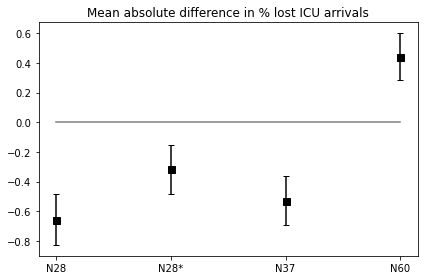

In [6]:
x_ticks = ("N28", "N28*", "N37", "N60")

x_1 = np.arange(1, 5)

y_1 = [mean_diff_ci95[net,'diff_policyDET'][1] for net in networks]
y_2 = [0, 0, 0, 0]

err_1 = [mean_diff_ci95[net,'diff_policyDET'][1]-mean_diff_ci95[net,'diff_policyDET'][0] for net in networks]

plt.errorbar(x=x_1, y=y_1, yerr=err_1, color="black", capsize=3,
             linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
plt.plot(x_1, y_2, color='gray')

plt.xticks(x_1, x_ticks)
plt.title('Mean absolute difference in % lost ICU arrivals')

plt.tight_layout()
#plt.show()
plt.savefig('lost_arrivalsdiffCI_grayscale.pdf', dpi=1200, bbox_inches='tight');

In [7]:
mean_diff_ci95 = {}
mean_diff_ci90 = {}

for net in networks:
    for sol in ['policyNEW', 'policyOPT', 'policyRMI', 'policyDET']:
        for day in range(1,8):
            mean_p1 = np.mean(lost_icu[net,'policy1',day])
            std_p1 = np.std(lost_icu[net,'policy1',day])
            mean_other = np.mean(lost_icu[net,sol,day])
            std_other = np.std(lost_icu[net,sol,day])
            s_p = sqrt((44199*std_p1**2 + 44199*std_other**2)/(44200+44200-2))
            se_95 = 1.96*s_p*sqrt(1/44200+1/44200)
            se_90 = 1.645*s_p*sqrt(1/44200+1/44200)
            mean_diff_ci95[net,'diff_'+sol,day] = (mean_p1-mean_other-se_95, mean_p1-mean_other, mean_p1-mean_other+se_95)
            mean_diff_ci90[net,'diff_'+sol,day] = (mean_p1-mean_other-se_90, mean_p1-mean_other, mean_p1-mean_other+se_90)

In [8]:
net = 60

for d in range(1,8):
    print(d, mean_diff_ci95[net,'diff_policyDET',d][1])
    
print('Average change')
print(np.mean([mean_diff_ci95[net,'diff_policyDET',d][1] for d in range(1,8)]))

1 0.18306933097597522
2 1.0443089012546025
3 0.7021736433501147
4 -0.2599628651891095
5 -0.4482891718638271
6 1.1821482112658543
7 0.6915094809664986
Average change
0.442136790108587


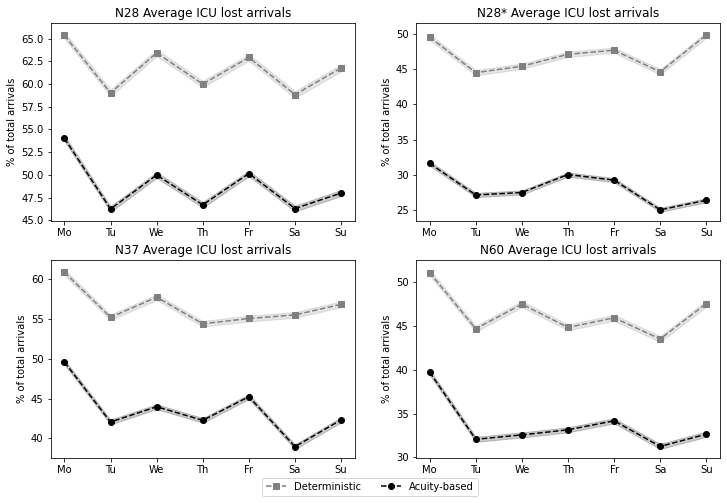

In [10]:
# Replace Figure 4 in R1

fig, axarr = plt.subplots(2, 2, sharey=False, figsize=(12,8))

for k in [[0,0,28], [0,1,'28_2'], [1,0,37], [1,1,60]]:
    r = k[0]
    l = k[1]
    n = k[2]
    
    axarr[r,l].plot(range(1,8), [np.mean(lost_icu[n,'policyNEW',d]) for d in range(1,8)], linestyle='--', marker='s', color='gray', label='Deterministic')
    axarr[r,l].fill_between(range(1,8), [lost_icu_ci[n,'policyNEW',d][0] for d in range(1,8)], [lost_icu_ci[n,'policyNEW',d][1] for d in range(1,8)], color='gray', alpha=0.2)
    
    axarr[r,l].plot(range(1,8), [np.mean(lost_icu[n,'policy1',d]) for d in range(1,8)], linestyle='--', marker='o', color='black', label='Acuity-based')
    axarr[r,l].fill_between(range(1,8), [lost_icu_ci[n,'policy1',d][0] for d in range(1,8)], [lost_icu_ci[n,'policy1',d][1] for d in range(1,8)], color='black', alpha=0.2)
    
    axarr[r,l].set_title('N'+str(n)+' Average ICU lost arrivals')
    axarr[r,l].set_ylabel('% of total arrivals')
    axarr[0,1].set_title('N28*'+' Average ICU lost arrivals')
    axarr[r,l].set_xticks([1,2,3,4,5,6,7])
    axarr[r,l].set_xticklabels(['Mo','Tu','We','Th','Fr','Sa','Su'])

handles, labels = axarr[r,l].get_legend_handles_labels()
axarr[1,0].legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(1.05, -0.1),borderaxespad=0)
#plt.tight_layout()
plt.savefig('lost_arrivalsDetvsAcCI_grayscale.pdf', dpi=1200, bbox_inches='tight');

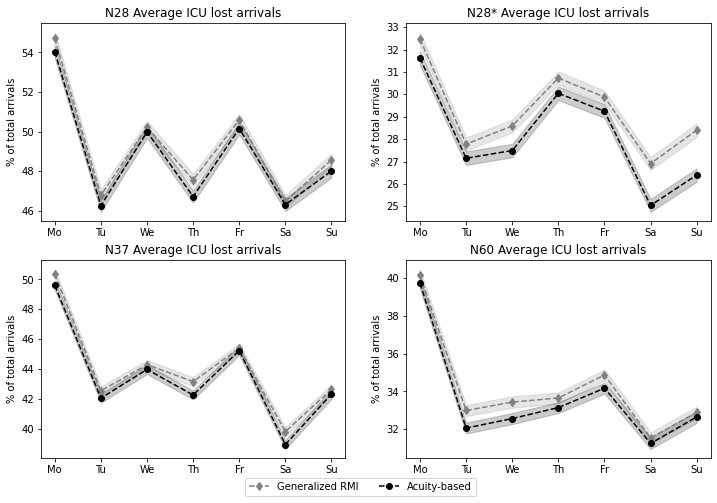

In [11]:
fig, axarr = plt.subplots(2, 2, sharey=False, figsize=(12,8))

for k in [[0,0,28], [0,1,'28_2'], [1,0,37], [1,1,60]]:
    r = k[0]
    l = k[1]
    n = k[2]
    
    axarr[r,l].plot(range(1,8), [np.mean(lost_icu[n,'policyRMI',d]) for d in range(1,8)], linestyle='--', marker='d', color='gray', label='Generalized RMI')
    axarr[r,l].fill_between(range(1,8), [lost_icu_ci[n,'policyRMI',d][0] for d in range(1,8)], [lost_icu_ci[n,'policyRMI',d][1] for d in range(1,8)], color='gray', alpha=0.2)
    
    axarr[r,l].plot(range(1,8), [np.mean(lost_icu[n,'policy1',d]) for d in range(1,8)], linestyle='--', marker='o', color='black', label='Acuity-based')
    axarr[r,l].fill_between(range(1,8), [lost_icu_ci[n,'policy1',d][0] for d in range(1,8)], [lost_icu_ci[n,'policy1',d][1] for d in range(1,8)], color='black', alpha=0.2)
    
    axarr[r,l].set_title('N'+str(n)+' Average ICU lost arrivals')
    axarr[r,l].set_ylabel('% of total arrivals')
    axarr[0,1].set_title('N28*'+' Average ICU lost arrivals')
    axarr[r,l].set_xticks([1,2,3,4,5,6,7])
    axarr[r,l].set_xticklabels(['Mo','Tu','We','Th','Fr','Sa','Su'])

handles, labels = axarr[r,l].get_legend_handles_labels()
axarr[1,0].legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(1.05, -0.1),borderaxespad=0)
plt.savefig('lost_arrivalsRMIvsAcCI_grayscale.pdf', dpi=1200, bbox_inches='tight');

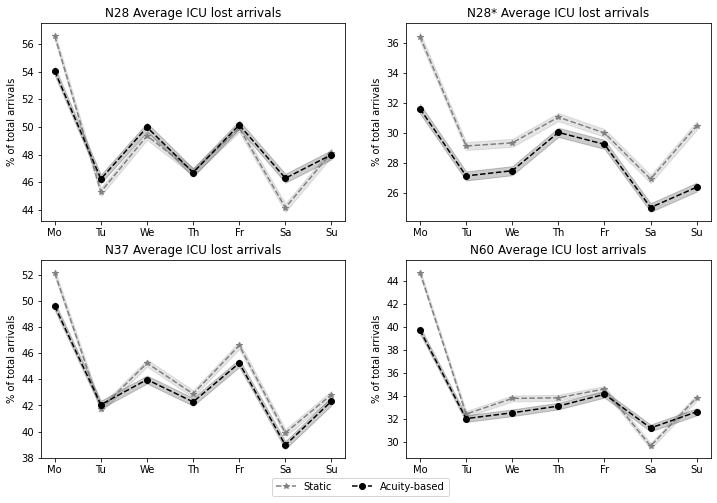

In [12]:
# Replace Figure 4 in R1

fig, axarr = plt.subplots(2, 2, sharey=False, figsize=(12,8))

for k in [[0,0,28], [0,1,'28_2'], [1,0,37], [1,1,60]]:
    r = k[0]
    l = k[1]
    n = k[2]
    
    axarr[r,l].plot(range(1,8), [np.mean(lost_icu[n,'policyOPT',d]) for d in range(1,8)], linestyle='--', marker='*', color='gray', label='Static')
    axarr[r,l].fill_between(range(1,8), [lost_icu_ci[n,'policyOPT',d][0] for d in range(1,8)], [lost_icu_ci[n,'policyOPT',d][1] for d in range(1,8)], color='gray', alpha=0.2)
    
    axarr[r,l].plot(range(1,8), [np.mean(lost_icu[n,'policy1',d]) for d in range(1,8)], linestyle='--', marker='o', color='black', label='Acuity-based')
    axarr[r,l].fill_between(range(1,8), [lost_icu_ci[n,'policy1',d][0] for d in range(1,8)], [lost_icu_ci[n,'policy1',d][1] for d in range(1,8)], color='black', alpha=0.2)


    
    axarr[r,l].set_title('N'+str(n)+' Average ICU lost arrivals')
    axarr[r,l].set_ylabel('% of total arrivals')
    axarr[0,1].set_title('N28*'+' Average ICU lost arrivals')
    axarr[r,l].set_xticks([1,2,3,4,5,6,7])
    axarr[r,l].set_xticklabels(['Mo','Tu','We','Th','Fr','Sa','Su'])

handles, labels = axarr[r,l].get_legend_handles_labels()
axarr[1,0].legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(1.05, -0.1),borderaxespad=0)
plt.savefig('lost_arrivalsStavsAcCI_grayscale.pdf', dpi=1200, bbox_inches='tight');